In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [17]:
data = pd.read_csv(r'Fraud_200k_sample.csv')

In [18]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [19]:
data = data[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
         'oldbalanceDest', 'newbalanceDest', 'isFraud']]

In [20]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,278,CASH_IN,330218.42,20866.00,351084.42,452419.57,122201.15,0
1,15,PAYMENT,11647.08,30370.00,18722.92,0.00,0.00,0
2,10,CASH_IN,152264.21,106589.00,258853.21,201303.01,49038.80,0
3,403,TRANSFER,1551760.63,0.00,0.00,3198359.45,4750120.08,0
4,206,CASH_IN,78172.30,2921331.58,2999503.88,415821.90,337649.60,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   oldbalanceOrg   200000 non-null  float64
 4   newbalanceOrig  200000 non-null  float64
 5   oldbalanceDest  200000 non-null  float64
 6   newbalanceDest  200000 non-null  float64
 7   isFraud         200000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 12.2+ MB


### Hot encoding

In [22]:
data = pd.get_dummies(data)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   amount          200000 non-null  float64
 2   oldbalanceOrg   200000 non-null  float64
 3   newbalanceOrig  200000 non-null  float64
 4   oldbalanceDest  200000 non-null  float64
 5   newbalanceDest  200000 non-null  float64
 6   isFraud         200000 non-null  int64  
 7   type_CASH_IN    200000 non-null  bool   
 8   type_CASH_OUT   200000 non-null  bool   
 9   type_DEBIT      200000 non-null  bool   
 10  type_PAYMENT    200000 non-null  bool   
 11  type_TRANSFER   200000 non-null  bool   
dtypes: bool(5), float64(5), int64(2)
memory usage: 11.6 MB


### Normalización y split

In [24]:
X = data.drop('isFraud', axis=1)
y = data['isFraud'].astype(int)

# Normalizando la data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
xgboost = XGBClassifier()

### Grid search

In [26]:
param_grid = {
    'n_estimators': [70, 140, 170],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.4, 0.7, 0.8],
    'max_depth': [4,5]
}

In [27]:
grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 5], 'n_estimators': [70, 140, 170],
                         'subsample': [0.4, 0.7, 0.8]},
             scoring='roc_auc', verbose=1)

Mejores parametros:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 170, 'subsample': 0.8}
Accuracy:  1.0
[[39940     1]
 [   15    44]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

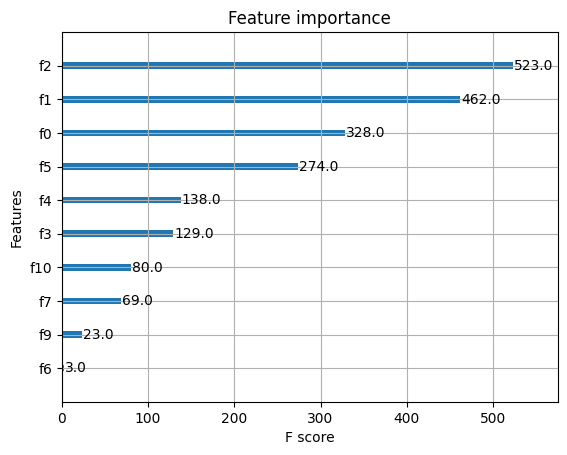

In [28]:
print("Mejores parametros: ", grid_search.best_params_)

# Predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = round(accuracy_score(y_test, y_pred),2)
print("Accuracy: ", accuracy)

print(confusion_matrix(y_test, y_pred))

plot_importance(grid_search.best_estimator_)

### Random search

In [29]:
random_search = RandomizedSearchCV(estimator=xgboost, param_distributions=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_iter=20)

# Fit
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [4, 5],
                                        'n_estimators': [70, 140, 170],
                                        'subsample': [0.4, 0.7, 0.8]},
                   scoring='accuracy', verbose=1)

In [31]:
print("Mejores parametros: ", random_search.best_params_)

# Predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print(confusion_matrix(y_test, y_pred))

Mejores parametros:  {'subsample': 0.7, 'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.1}
Accuracy:  0.999625
[[39941     0]
 [   15    44]]
